In [1]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 525 µs (started: 2022-07-23 01:29:24 +05:30)


In [33]:
sbox = (
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16)

def intermediate(pt, keyguess):
    return sbox[pt ^ keyguess]
    # return pt^keyguess

HW = [bin(n).count("1") for n in range(0, 256)]

time: 5.1 ms (started: 2022-07-23 01:59:47 +05:30)


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
from scipy.stats import linregress
import concurrent.futures
from concurrent.futures import as_completed
import seaborn as sns
import time
import rich as r
from IPython.display import clear_output # type: ignore

# load the .npy files
known_keys = np.load('cw_data/known_keys.npy')
textin_array = np.load('cw_data/textin_array.npy')
trace_array = np.load('cw_data/trace_array.npy')


time: 33.2 ms (started: 2022-07-23 02:47:43 +05:30)


In [4]:
print(known_keys.shape)
print(textin_array.shape)
print(trace_array.shape)

(2500, 16)
(2500, 16)
(2500, 5000)
time: 1.61 ms (started: 2022-07-23 01:29:30 +05:30)


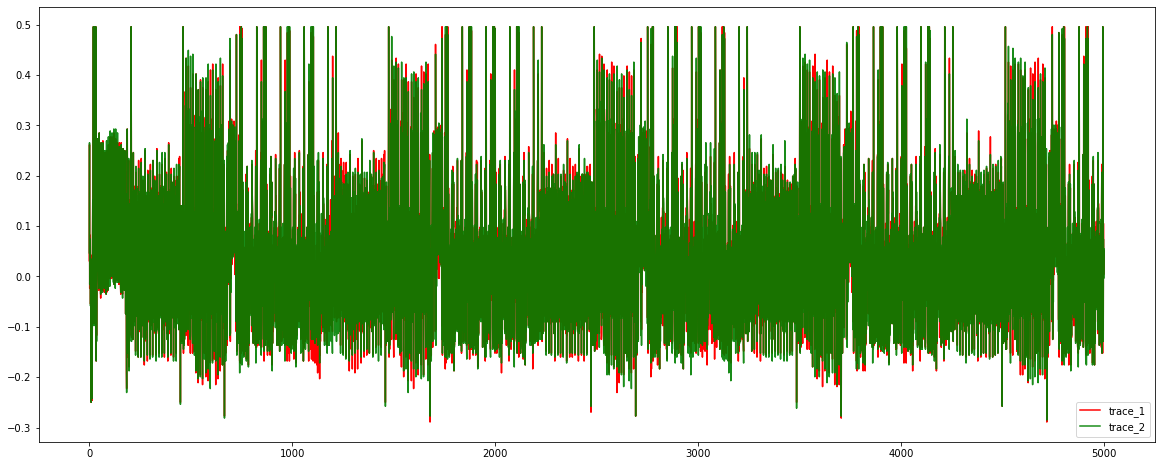

time: 347 ms (started: 2022-07-23 01:29:31 +05:30)


In [5]:
%matplotlib inline
plt.figure(figsize=(20,8))
plt.plot(trace_array[0], alpha=1, color='red', label='trace_1')
plt.plot(trace_array[1], alpha=0.9, color='green', label='trace_2')
plt.legend()
plt.show()

# DOM Attack

In [52]:
mean_diffs = np.zeros(256)
key_guess = []
# numtraces = trace_array.shape[0]
numtraces = 350
plots = []

for subkey in tnrange(0, 16, desc="Total Progress"):
    for kguess in tnrange(256, desc=f"Attacking Subkey {subkey}", leave=False):
        one_list = []
        zero_list = []

        for trace_no in range(numtraces):
            if (intermediate(textin_array[trace_no][subkey], kguess) & 1):
                one_list.append(trace_array[trace_no])
            else:
                zero_list.append(trace_array[trace_no])

        one_avg = np.asarray(one_list).mean(axis=0)
        zero_avg = np.asarray(zero_list).mean(axis=0)
        mean_diffs[kguess] = np.max(abs(one_avg - zero_avg))

        if kguess == known_keys[0][subkey]:
            plots.append(one_avg - zero_avg)

    guess = np.argsort(mean_diffs)[-1]
    key_guess.append(guess)
    clear_output(wait=True)
    display(key_guess)

[43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60]

time: 13.5 s (started: 2022-07-23 02:49:10 +05:30)


In [53]:
print("guess: ", [hex(x)[2:] for x in key_guess])
print("actual: ", [hex(x)[2:] for x in known_keys[0]])

guess:  ['2b', '7e', '15', '16', '28', 'ae', 'd2', 'a6', 'ab', 'f7', '15', '88', '9', 'cf', '4f', '3c']
actual:  ['2b', '7e', '15', '16', '28', 'ae', 'd2', 'a6', 'ab', 'f7', '15', '88', '9', 'cf', '4f', '3c']
time: 1.71 ms (started: 2022-07-23 02:49:24 +05:30)


In [114]:
fmt = "{:02X}<br>{:.3f}"
def format_stat(stat):
    return str(fmt.format(stat[0], stat[1]))


def color_corr_key(row):
    # print(len(row))
    ret = [""] * len(row)
    for i, bnum in enumerate(row):
        if i == 0:
            ret[i] = "color: green"
        else:
            ret[i] = "color: red"
    return ret

time: 1.56 ms (started: 2022-07-23 03:35:42 +05:30)


In [118]:
import pandas as pd
mean_diffs = np.zeros(256)
key_guess = []
# numtraces = trace_array.shape[0]
numtraces = 350
plots = []
printable = []

for subkey in tnrange(0, 16, desc="Total Progress"):
    temp = []  # to store the keybyte and the dom
    for kguess in tnrange(256, desc=f"Attacking Subkey {subkey}", leave=False):
        one_list = []
        zero_list = []

        for trace_no in range(numtraces):
            if (intermediate(textin_array[trace_no][subkey], kguess) & 1):
                one_list.append(trace_array[trace_no])
            else:
                zero_list.append(trace_array[trace_no])

        one_avg = np.asarray(one_list).mean(axis=0)
        zero_avg = np.asarray(zero_list).mean(axis=0)
        mean_diffs[kguess] = np.max(abs(one_avg - zero_avg))

        temp.append((kguess, mean_diffs[kguess]))  # add the data kguess, dom

        if kguess == known_keys[0][subkey]:
            plots.append(one_avg - zero_avg)

    temp.sort(key = lambda x: -x[1])  # sort temp by dom value
    printable.append(temp)  # add the data in list
    df = pd.DataFrame(printable).transpose()

    guess = np.argsort(mean_diffs)[-1]
    key_guess.append(guess)

    clear_output(wait=True)  # clear the previous output
    display(df.head().style.format(format_stat).apply(color_corr_key, axis=0))  # display the current status

time: 13.8 s (started: 2022-07-23 03:37:50 +05:30)


In [116]:
# display(df.head().style.format(format_stat).apply(color_corr_key, axis=1))
# '2b', '7e', '15', '16', '28', 'ae', 'd2', 'a6', 'ab', 'f7', '15', '88', '9', 'cf', '4f', '3c'

time: 651 µs (started: 2022-07-23 03:36:45 +05:30)


In [131]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.palettes import brewer

output_notebook()
p = figure(plot_width=1000, plot_height=400)

bnum = 0

# xrange = range(len(trace_array[0]))
xrange = range(100)
color_mapper = (brewer['Reds'][9])

for _ , trace in enumerate(trace_array):
    hw = HW[intermediate(textin_array[_][bnum], known_keys[_][bnum])]
    p.line(xrange, trace[500:600], line_color=color_mapper[hw])

show(p)

Loading BokehJS ...

time: 17.3 s (started: 2022-07-23 03:51:48 +05:30)


## Using a better leakage model (Hamming weight)

In [127]:
mean_diffs = np.zeros(256)
key_guess = []
# numtraces = trace_array.shape[0]
numtraces = 75
plots = []

for subkey in tnrange(0, 16, desc="Total Progress"):
    for kguess in tnrange(256, desc=f"Attacking Subkey {subkey}", leave=False):
        one_list = []
        zero_list = []

        for trace_no in range(numtraces):
            hw = HW[intermediate(textin_array[trace_no][subkey], kguess)]
            if hw > 4:
                one_list.append(trace_array[trace_no])
            else:
                zero_list.append(trace_array[trace_no])

        one_avg = np.asarray(one_list).mean(axis=0)
        zero_avg = np.asarray(zero_list).mean(axis=0)
        mean_diffs[kguess] = np.max(abs(one_avg - zero_avg))

        if kguess == known_keys[0][subkey]:
            plots.append(one_avg - zero_avg)

    guess = np.argsort(mean_diffs)[-1]
    key_guess.append(guess)
    clear_output(wait=True)
    display(key_guess)

print("guess: ", [hex(x)[2:] for x in key_guess])
print("actual: ", [hex(x)[2:] for x in known_keys[0]])

[43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60]

guess:  ['2b', '7e', '15', '16', '28', 'ae', 'd2', 'a6', 'ab', 'f7', '15', '88', '9', 'cf', '4f', '3c']
actual:  ['2b', '7e', '15', '16', '28', 'ae', 'd2', 'a6', 'ab', 'f7', '15', '88', '9', 'cf', '4f', '3c']
time: 2.66 s (started: 2022-07-23 03:40:51 +05:30)


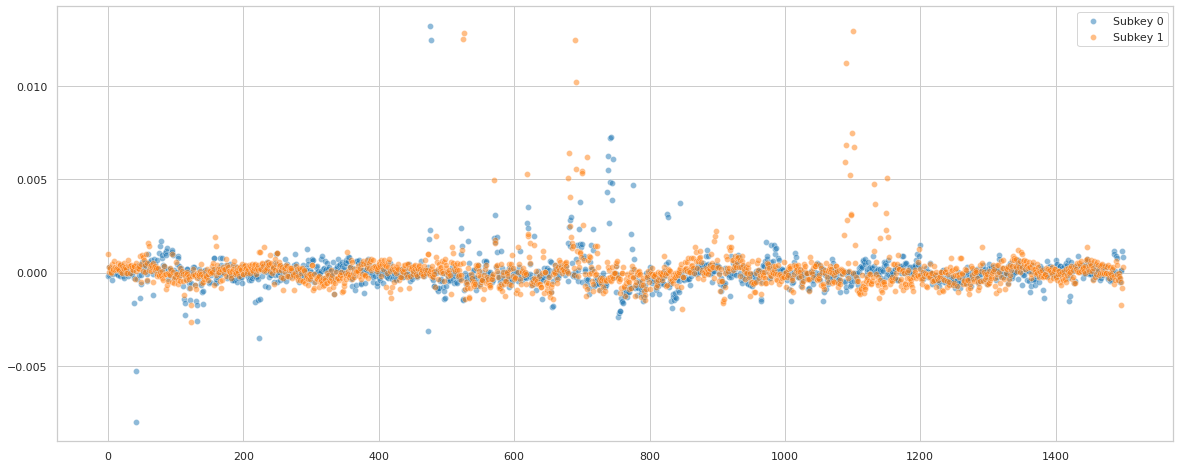

time: 244 ms (started: 2022-07-18 21:39:28 +05:30)


In [9]:
num_subkeys = 2
plt.figure(figsize=(20,8))
sns.set_style("whitegrid", {"axes.facecolor": "1"})
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1.5})

for i in range(num_subkeys):
    # plt.plot(plots[i][0:1500], alpha=0.5)
    # plt.scatter(range(1500), plots[i][0:1500], alpha=0.5)
    sns.scatterplot(x=range(1500), y=plots[i][0:1500], alpha=0.5, )

plt.legend(["Subkey {}".format(x) for x in range(num_subkeys)])
plt.show()

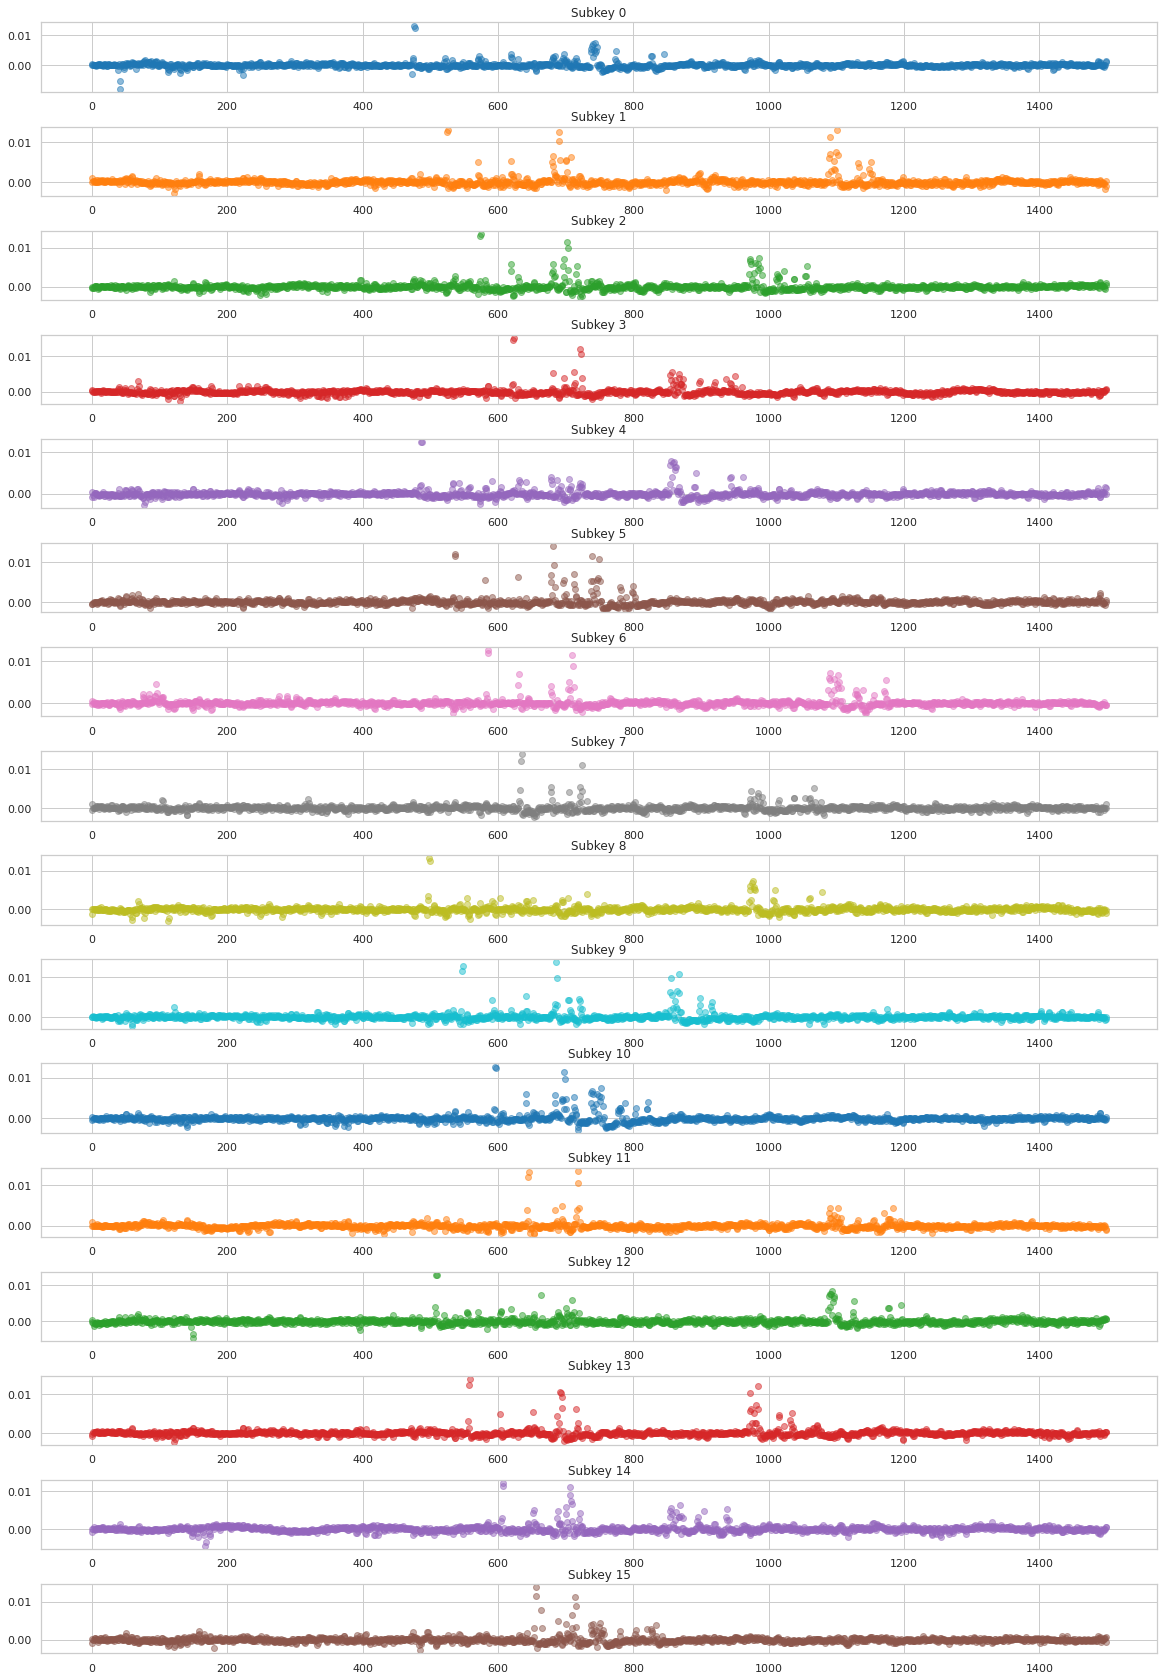

time: 1.69 s (started: 2022-07-18 21:39:31 +05:30)


In [10]:
fig, axs = plt.subplots(nrows=16, ncols=1, figsize=(20, 30))
plt.subplots_adjust(hspace=0.5)
colors = plt.rcParams["axes.prop_cycle"]()
# fig.suptitle("DOM", fontsize=18, y=0.95)

for _, ax in enumerate(axs):
    c = next(colors)["color"]
    # ax.plot(plots[_][0:1500], alpha=0.5)
    ax.scatter(range(1500), plots[_][0:1500], color=c, alpha=0.5)
    ax.set_title("Subkey {}".format(_))
plt.show()


## Running DOM Attack on Multicore

In [6]:
numtraces = trace_array.shape[0]

def attack_subkey(subkey):
    mean_diffs = np.zeros(256)
    for kguess in tnrange(256, desc="Keyguess", leave=False):
        one_list = []
        zero_list = []

        for trace_no in range(numtraces):
            if (intermediate(textin_array[trace_no][subkey], kguess) & 1):
                one_list.append(trace_array[trace_no])
            else:
                zero_list.append(trace_array[trace_no])

        one_avg = np.asarray(one_list).mean(axis=0)
        zero_avg = np.asarray(zero_list).mean(axis=0)
        mean_diffs[kguess] = np.max(abs(one_avg - zero_avg))
    return [np.argsort(mean_diffs)[-1], mean_diffs]

time: 737 µs (started: 2022-07-19 01:38:10 +05:30)


In [7]:
with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
    results = executor.map(attack_subkey, range(16))
    
    results = [r for r in results]
    key_guess = [r[0] for r in results]
    DOM = [r[1] for r in results]


time: 53.7 s (started: 2022-07-19 01:38:12 +05:30)


In [21]:
def attack_subkey(subkey):
    mean_diffs = np.zeros(256)
    for kguess in tnrange(256, desc="Keyguess", leave=False):
        one_list = []
        zero_list = []

        for trace_no in range(numtraces):
            if (intermediate(textin_array[trace_no][subkey], kguess) & 1):
                one_list.append(trace_array[trace_no])
            else:
                zero_list.append(trace_array[trace_no])

        one_avg = np.asarray(one_list).mean(axis=0)
        zero_avg = np.asarray(zero_list).mean(axis=0)
        mean_diffs[kguess] = np.max(abs(one_avg - zero_avg))
    return [np.argsort(mean_diffs)[-1], mean_diffs, subkey]

with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(attack_subkey, i) for i in range(0,16)]
    
    for future in as_completed(futures):
        result = future.result()
        print(f"Subkey #{result[2]}: {result[0]}")


Subkey #4: 40
Subkey #7: 166
Subkey #3: 22
Subkey #5: 174
Subkey #6: 210
Subkey #0: 43
Subkey #1: 126
Subkey #2: 21
Subkey #9: 247
Subkey #11: 136
Subkey #10: 21
Subkey #8: 171
Subkey #15: 60
Subkey #14: 79
Subkey #13: 207
Subkey #12: 9
time: 52.8 s (started: 2022-07-19 02:32:09 +05:30)


In [22]:
for _, future in enumerate(futures):
    result = future.result()
    print(f"Subkey #{_}: {result[0]}")

Subkey #0: 43
Subkey #1: 126
Subkey #2: 21
Subkey #3: 22
Subkey #4: 40
Subkey #5: 174
Subkey #6: 210
Subkey #7: 166
Subkey #8: 171
Subkey #9: 247
Subkey #10: 21
Subkey #11: 136
Subkey #12: 9
Subkey #13: 207
Subkey #14: 79
Subkey #15: 60
time: 3.98 ms (started: 2022-07-19 02:33:56 +05:30)


In [13]:
# Note: Another method to write multiprocess code

from tqdm.contrib.concurrent import process_map

results = process_map(attack_subkey, range(0, 16), max_workers=8)
key_guess = [r[0] for r in results]
DOM = [r[1] for r in results]

  0%|          | 0/16 [00:00<?, ?it/s]

time: 51.6 s (started: 2022-07-18 21:40:52 +05:30)


In [14]:
key_guess

[43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60]

time: 4.3 ms (started: 2022-07-18 21:42:37 +05:30)


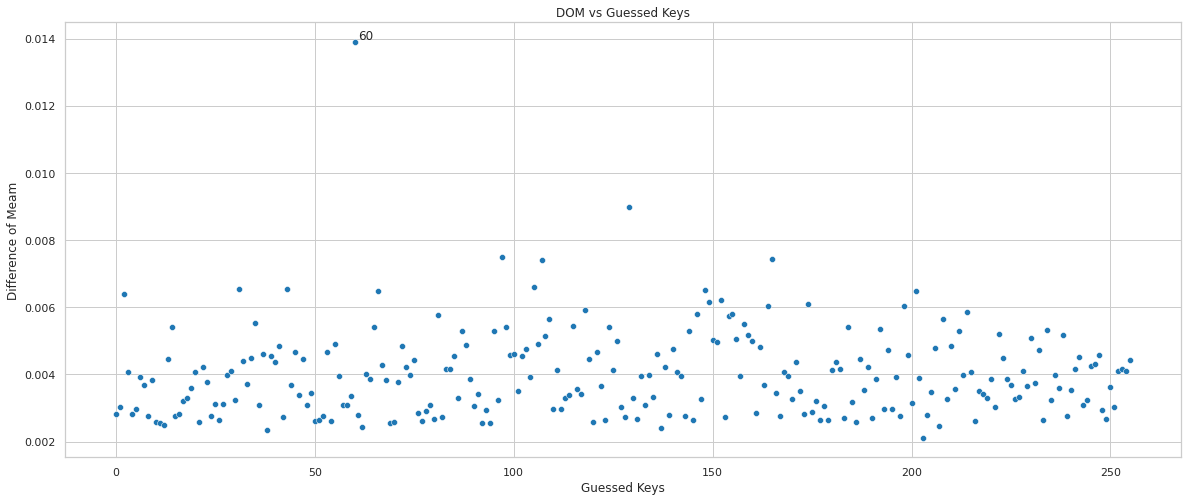

time: 210 ms (started: 2022-07-18 21:42:39 +05:30)


In [15]:
selected_subkey = 15

plt.figure(figsize=(20,8))
sns.scatterplot(x=range(DOM[selected_subkey].shape[0]), y=DOM[selected_subkey])

for i in range(256):
    max_dom = DOM[selected_subkey].max()
    if DOM[selected_subkey][i] == max_dom:
        plt.text(x=i + 1, y=max_dom + 0.0001, s=str(i))

plt.title("DOM vs Guessed Keys")
plt.xlabel("Guessed Keys")
plt.ylabel("Difference of Meam")
plt.show()

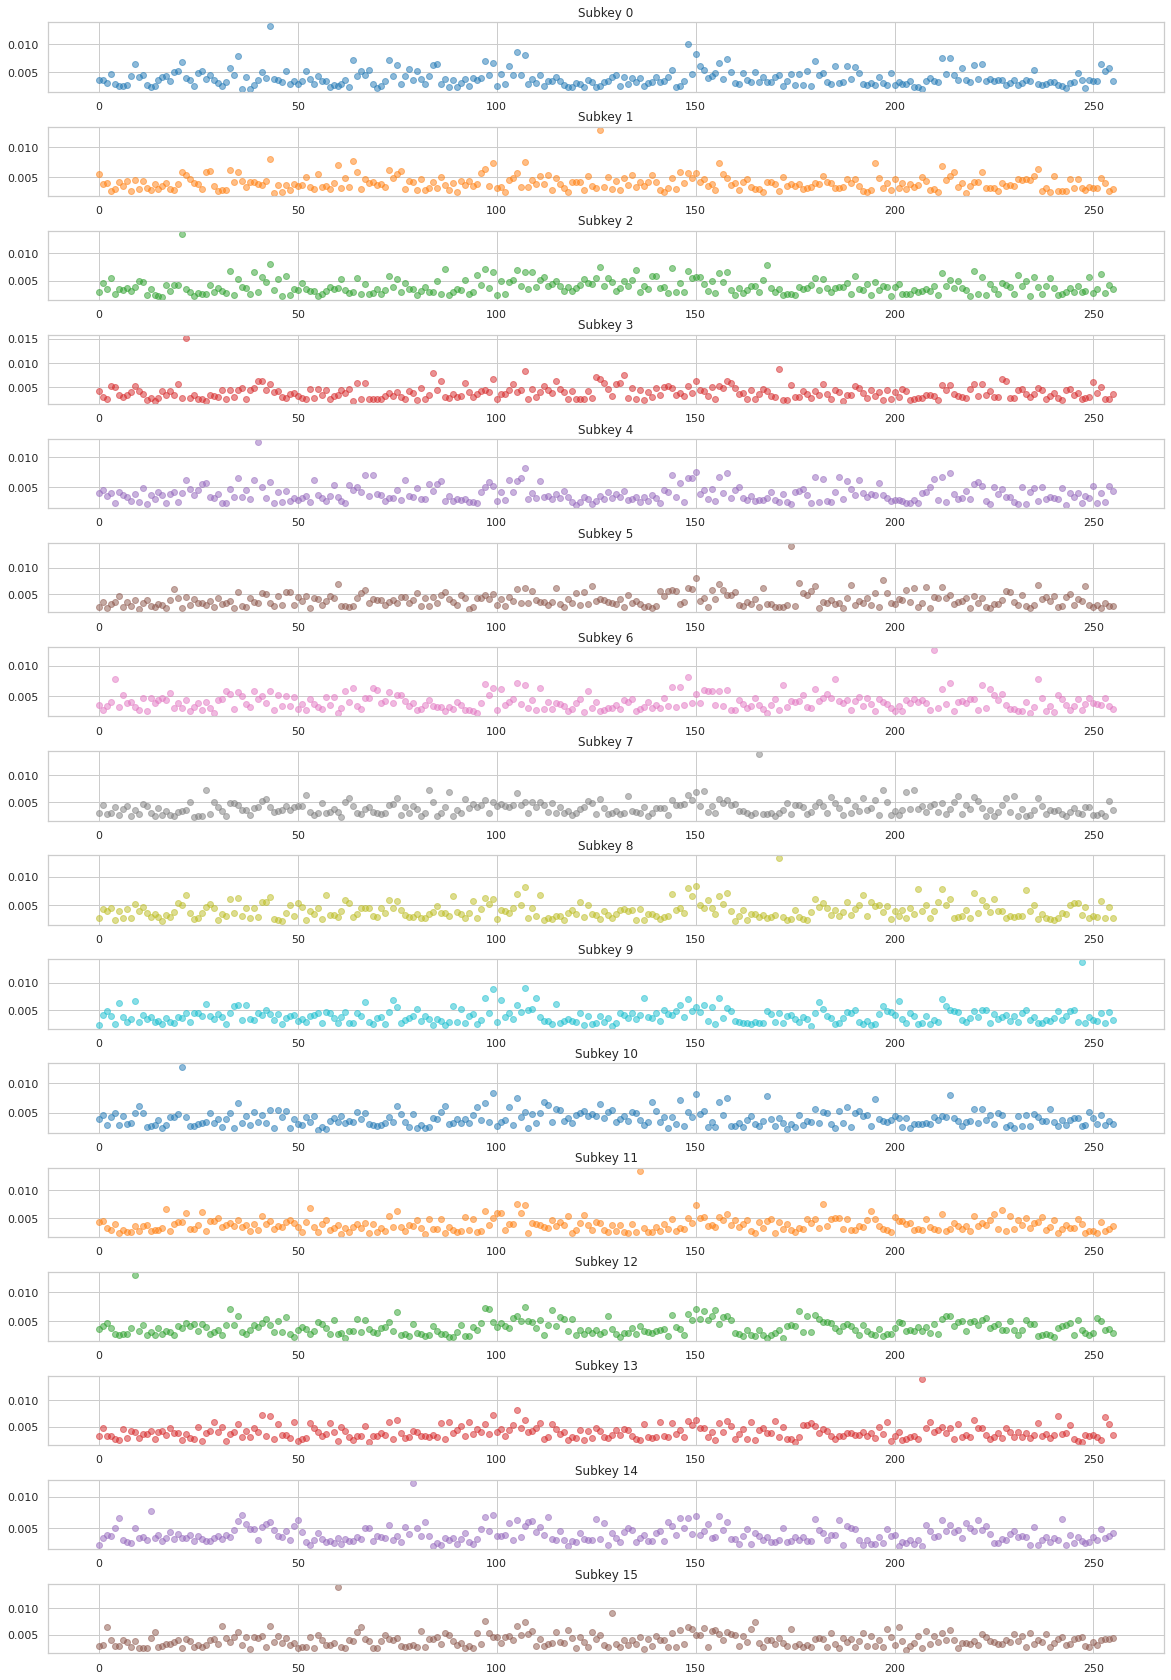

time: 1.43 s (started: 2022-07-18 23:01:57 +05:30)


In [22]:
fig, axs = plt.subplots(nrows=16, ncols=1, figsize=(20, 30))
plt.subplots_adjust(hspace=0.5)
colors = plt.rcParams["axes.prop_cycle"]()
# fig.suptitle("DOM", fontsize=18, y=0.95)

for _, ax in enumerate(axs):
    c = next(colors)["color"]
    # ax.plot(plots[_][0:1500], alpha=0.5)
    ax.scatter(range(256), y=DOM[_], color=c, alpha=0.5)
    ax.set_title("Subkey {}".format(_))
plt.show()

# CPA

In [16]:
# For last round attack
def leakage_2(ct, key, bnum):
    # HD Leakage of AES State between 9th and 10th Round
    st10 = ct[INVSHIFT_undo[bnum]]
    st9 = inv_sbox(ct[bnum] ^ key)
    return (st9 ^ st10)

HW = [bin(n).count("1") for n in range(0, 256)]

time: 1.69 ms (started: 2022-07-18 21:42:44 +05:30)


In [ ]:
# NOTE: It will take 80 mins to run with numpoints = 5000

key_guess = []
numtraces = trace_array.shape[0]
numpoints = trace_array.shape[1]
# numpoints = 1500

crvs = np.zeros((16, 256, numpoints))

HW_matrix = np.zeros((numtraces, 256), dtype=np.uint8)

for subkey in tnrange(0, 16, desc="Attacking Subkey"):
    for kguess in tnrange(0, 256, desc="Generating Hamming Weights"):
        # Generate the hamming weight matrix for each possible keybyte
        for trace_no in range(numtraces):
            iv = intermediate(textin_array[trace_no][subkey], kguess)
            HW_matrix[trace_no, kguess] = HW[iv]
            
        for point in range(numpoints):
            hw = HW_matrix[:, kguess]
            trc = trace_array[:, point]
            crvs[subkey, kguess, point] = np.abs(linregress(hw, trc).slope)
            
    key_guess.append(crvs[subkey].max(axis=1).argmax())
    print("subkey: ", subkey, "keyguess: ", key_guess[subkey])


In [ ]:
key_guess

## CPA on Multicore

In [17]:
numtraces = trace_array.shape[0]
numpoints = trace_array.shape[1]
# numpoints = 1500

crvs = np.zeros((256, numpoints))
HW_matrix = np.zeros((numtraces, 256), dtype=np.uint8)

def attack_subkey(subkey):
    for kguess in tnrange(0, 256, desc=f"Guessing subkey {subkey}"):
        # Generate the hamming weight matrix for each possible keybyte
        for trace_no in range(numtraces):
            iv = intermediate(textin_array[trace_no][subkey], kguess)
            HW_matrix[trace_no, kguess] = HW[iv]

        for point in range(numpoints):
            hw = HW_matrix[:, kguess]
            trc = trace_array[:, point]
            crvs[kguess, point] = np.abs(linregress(hw, trc).slope)

    return [crvs.max(axis=1).argmax(), crvs.max(axis=1)] 

# attack_subkey(0)

time: 3.65 ms (started: 2022-07-18 21:42:54 +05:30)


In [18]:
# NOTE: 4 cores took 20.5 mins for 1500 points
# NOTE: 8 (4 cores + 4 thread) took 22.43 mins for 1500 points
# NOTE: 8 core took 1h4 1min 15s for 5000 points

# with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
#     results = executor.map(attack_subkey, range(16))
    
#     results = [r for r in results]
#     key_guess = [r[0] for r in results]
#     crvs = [r[1] for r in results]
    
# Using method two
results = process_map(attack_subkey, range(0, 16), max_workers=8)
key_guess = [r[0] for r in results]
crvs = [r[1] for r in results]

  0%|          | 0/16 [00:00<?, ?it/s]

time: 1h 1min 15s (started: 2022-07-18 21:43:50 +05:30)


In [19]:
key_guess

[43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60]

time: 2.18 ms (started: 2022-07-18 23:00:01 +05:30)


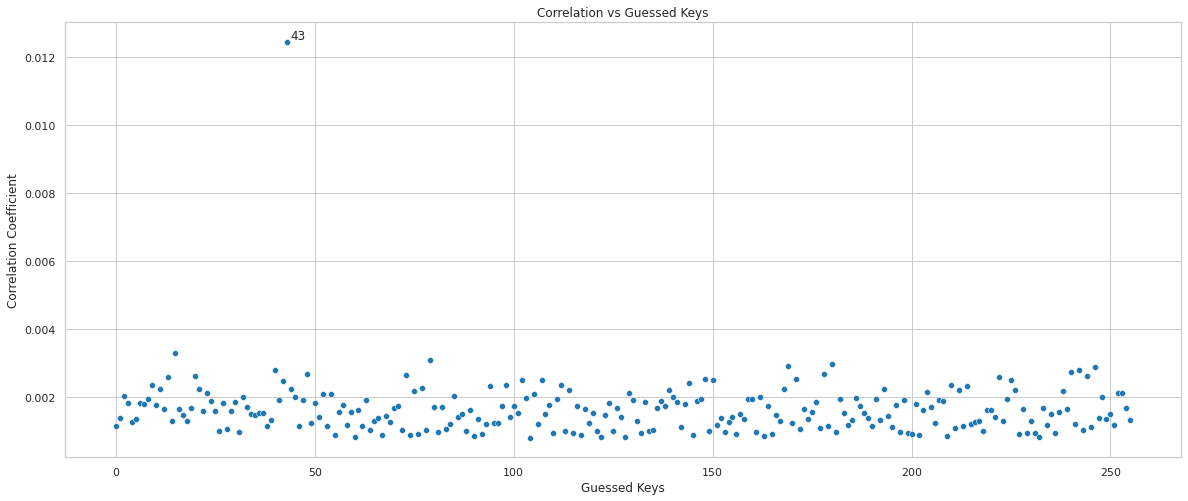

time: 161 ms (started: 2022-07-18 23:00:05 +05:30)


In [20]:
selected_subkey = 0

plt.figure(figsize=(20, 8))
sns.scatterplot(x=range(crvs[selected_subkey].shape[0]), y=crvs[selected_subkey])

for i in range(256):
    max_crv = crvs[selected_subkey].max()
    if crvs[selected_subkey][i] == max_crv:
        plt.text(x=i + 1, y=max_crv + 0.0001, s=str(i))

plt.title("Correlation vs Guessed Keys")
plt.xlabel("Guessed Keys")
plt.ylabel("Correlation Coefficient")
plt.show()


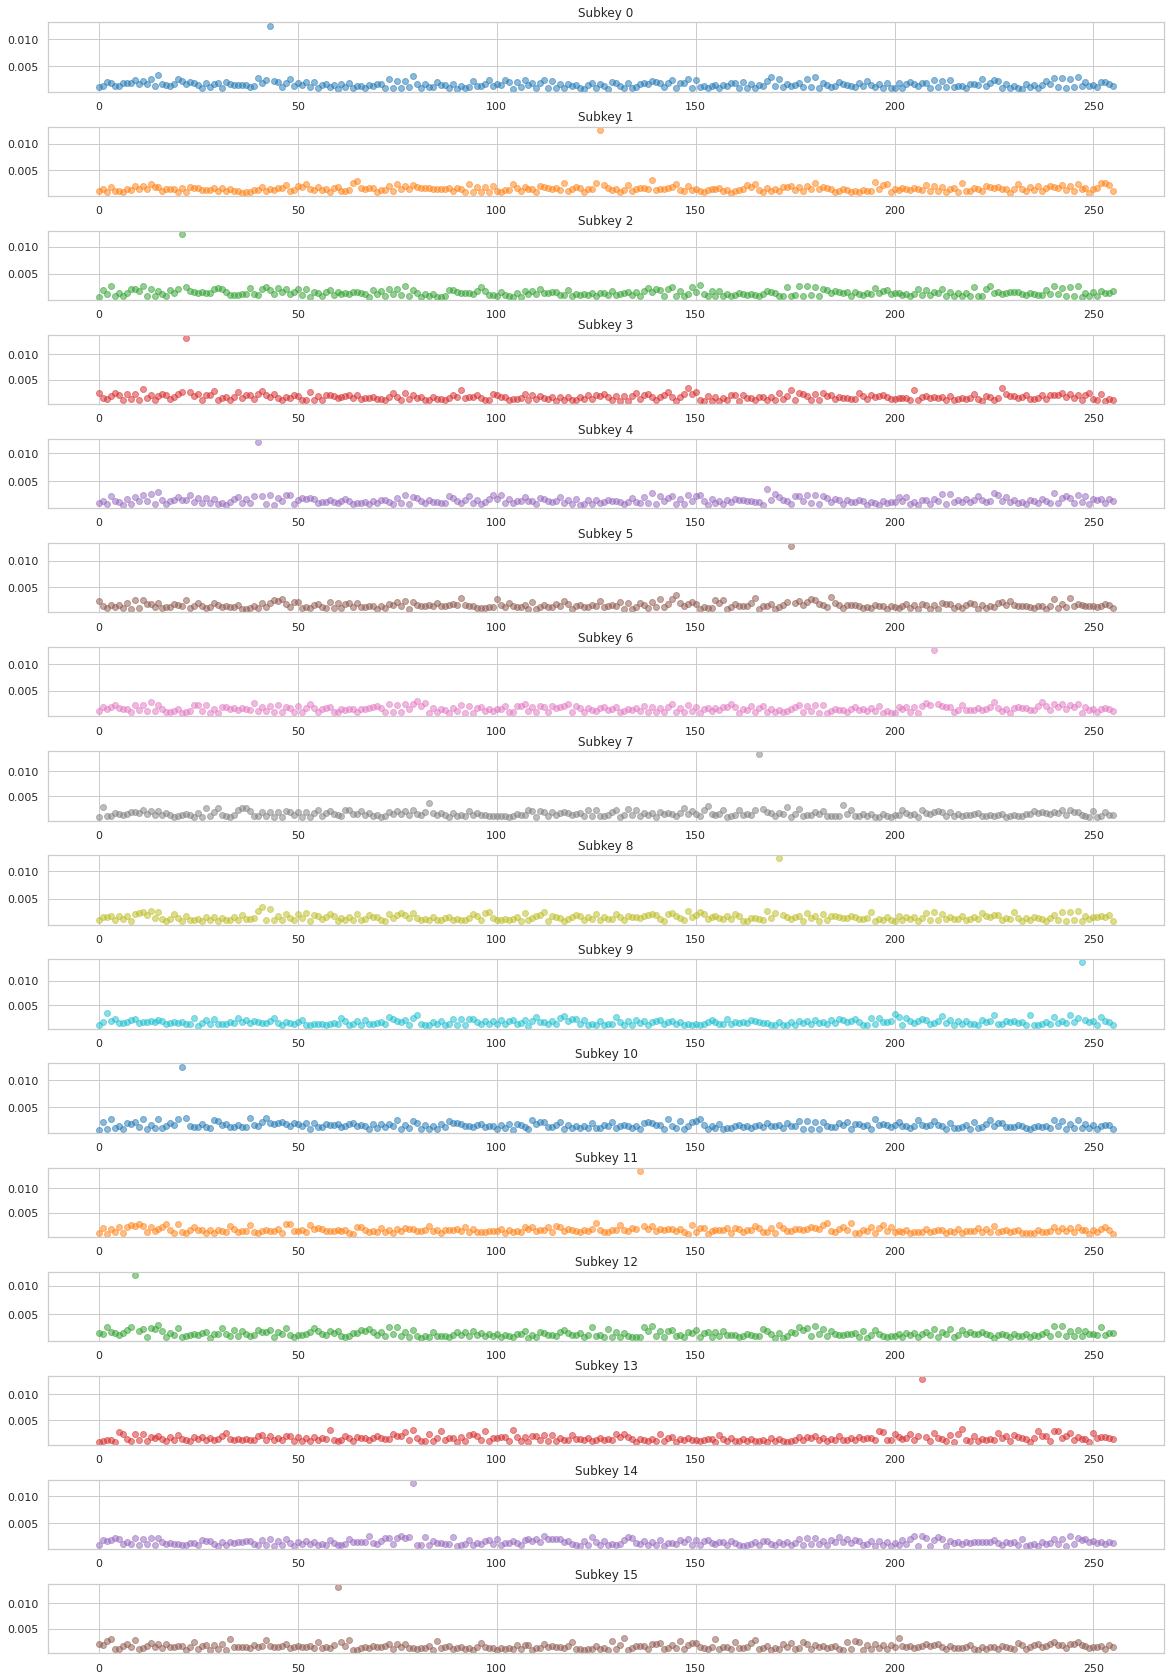

time: 1.6 s (started: 2022-07-18 23:00:07 +05:30)


In [21]:
fig, axs = plt.subplots(nrows=16, ncols=1, figsize=(20, 30))
plt.subplots_adjust(hspace=0.5)
colors = plt.rcParams["axes.prop_cycle"]()
# fig.suptitle("DOM", fontsize=18, y=0.95)

for _, ax in enumerate(axs):
    c = next(colors)["color"]
    # ax.plot(plots[_][0:1500], alpha=0.5)
    ax.scatter(range(256), crvs[_], color=c, alpha=0.5)
    ax.set_title("Subkey {}".format(_))
plt.show()


## Incremental CPA

Remember the objective is to calculate the following:
$$r_{i,j} = \frac{\sum_{d=1}^{D}[(h_{d,i} - \bar{h_i})(t_{d,j}-\bar{t_j})]}{\sqrt{\sum_{d=1}^D(h_{d,i}-\bar{h_i})^2\sum_{d=1}^D(t_{d,j}-\bar{t_j})^2}} $$

Where

| **Equation** | **Python Variable** | **Value**  | 
|--------------|---------------------|------------|
|  d           |       tnum          | trace number |
|  i           |       kguess        | subkey guess |
| j | j index trace point | sample point in trace |
| h | hypint | guess for power consumption | 
| t | traces | traces | 

It can be noticed there is effectively three sums, all sums are done over all traces. For this initial implementation we'll be explicitly calculating some of these sums, although it's faster to use NumPy to calculate across large arrays. We'll convert those three summations into variables, turning the equation into this format:

$$r_{i,j}=\frac{sumnum}{\sqrt{snumden1 * sumden2}}$$

Where:

$$sumnum = \sum_{d=1}^{D}[(h_{d,i} - \bar{h_i})(t_{d,j}-\bar{t_j})]$$

$$sumden1 = \sum_{d=1}^D(h_{d,i}-\bar{h_i})^2$$

$$sumden2 = \sum_{d=1}^D(t_{d,j}-\bar{t_j})^2$$

Looking at this, we can see that we'll need $\bar{h_i}$ and $\bar{t_j}$, so let's start by building some code that will give us those. Looking at the CPA tutorial, we can see that $h_{d,i}$ is just our guess for the power consumption in trace $d$ for subkey $i$. We can get that easily using the `HW` array and `intermediate()` function we defined earlier:

```python
for bnum in range(0, 16):
    cpaoutput = [0]*256
    maxcpa = [0]*256
    for kguess in range(0, 256):
        hyp = np.zeros(numtraces)
        for tnum in range(0, numtraces):
            hyp[tnum] = HW[intermediate(pt[tnum][bnum], kguess)]
```

Now we can get $\bar{h_i}$:
```python
meanh = np.mean(hyp, dtype=np.float64)
```

and $\bar{t_j}$ is just the mean of all of our traces:
```python
meant = np.mean(traces, axis=0, dtype=np.float64)
```

Next, let's move on to calculating the whole sums using $h_{d,i}$ and $t_{d,j}$ and the values we just calculated:

```python
#For each trace, do the following
for tnum in range(numtraces):
    hdiff = (hyp[tnum] - meanh)
    tdiff = traces[tnum,:] - meant

    sumnum = sumnum + (hdiff*tdiff)
    sumden1 = sumden1 + hdiff*hdiff 
    sumden2 = sumden2 + tdiff*tdiff
```

We can now get the correlation for each of our subkey guesses, which we'll call `cpaoutput[]`:

```python
cpaoutput[kguess] = sumnum / np.sqrt( sumden1 * sumden2 )
```

We're almost done! All that's left is to use that correlation to figure out which subkey best matches our power traces. First off, we only care about absolute value of the correlation (that there is a linear correlation), not sign. Additionally, though this didn't factor into our correlation calculation, remember that each trace was actually made up of a bunch of sample points. This means that what we actually have is the correlation of each subkey guess to each sample point. Typically only a few points in the trace are correlating, and it's the maximum across the entire trace we are concerned with, so we can pick our correlation for each subkey by:

```python
maxcpa[kguess] = max(abs(cpaoutput[kguess]))
```

Finally, we can find the subkey that best matches our data by finding the one with the biggest correlation:

```python
bestguess[bnum] = np.argmax(maxcpa)
```

The implementation of the correlation function runs as a loop over all traces. Ideally we'd like to implement this as a 'online' calculation; that is, we can add a trace in, observe the output, add another trace in, observe the output, etc. When generating plots of the Partial Guessing Entropy (PGE) vs. number of traces this is greatly preferred, since otherwise we need to run the loop many times!

We can use an alternate form of the correlation equation, which explicitly stores sums of the variables. This is easier to perform online calculation with, since when adding a new trace it's simple to update these sums. This form of the equation looks like:

$$r_{i,j} = \frac{D\sum_{d=1}^{D}h_{d,i}t_{d,j}-\sum_{d=1}^{D}h_{d,i}\sum_{d=1}^{D}t_{d,j}}{\sqrt{((\sum_{d=1}^Dh_{d,i})^2-D\sum_{d=1}^Dh_{d,i}^2)-((\sum_{d=1}^Dt_{d,j})^2-D\sum_{d=1}^Dh_{d,j}^2)}} $$

In [ ]:
class CPAProgressiveOneSubkey(object):
    def __init__(self, model):
        self.model = model
            self.sumhq = [0] * self.model.getPermPerSubkey()
        self.sumtq = [0]
        self.sumt = [0]
        self.sumh = [0] * self.model.getPermPerSubkey()
        self.sumht = [0] * self.model.getPermPerSubkey()
        self.totalTraces = 0

    def oneSubkey(self, bnum, pointRange, traces_all, numtraces, plaintexts, ciphertexts):
        diffs = [0] * self.model.getPermPerSubkey()
        self.totalTraces += numtraces

        if pointRange == None:
            traces = traces_all
        else:
            traces = traces_all[:, pointRange[0] : pointRange[1]]

        self.sumtq += np.sum(np.square(traces), axis=0, dtype=np.longdouble)
        self.sumt += np.sum(traces, axis=0, dtype=np.longdouble)
        sumden2 = np.square(self.sumt) - self.totalTraces * self.sumtq

        #For each 0..0xFF possible value of the key byte
        for key in range(0, self.model.getPermPerSubkey()):
            #Initialize arrays & variables to zero
            sumnum = np.zeros(len(traces[0,:]))
            hyp = [0] * numtraces

            #Formula for CPA & description found in "Power Analysis Attacks"
            # by Mangard et al, page 124, formula 6.2.
            #
            # This has been modified to reduce computational requirements such that adding a new waveform
            # doesn't require you to recalculate everything

            #Generate hypotheticals
            for tnum in range(numtraces):
                if len(plaintexts) > 0:
                    pt = plaintexts[tnum]

                if len(ciphertexts) > 0:
                    ct = ciphertexts[tnum]

                hypint = self.model.leakage(pt, ct, key, bnum, state)

                hyp[tnum] = hypint

            hyp = np.array(hyp)

            self.sumh[key] += np.sum(hyp, axis=0, dtype=np.longdouble)
            self.sumht[key] += np.sum(np.multiply(np.transpose(traces), hyp), axis=1, dtype=np.longdouble)

            #WARNING: not casting to np.float64 causes algorithm degredation... always be careful
            #meanh = self.sumh[key] / np.float64(self.totalTraces)
            #meant = self.sumt[key] / np.float64(self.totalTraces)

            #numtraces * meanh * meant = sumh * meant
            #sumnum =  self.sumht[key] - meant*self.sumh[key] - meanh*self.sumt[key] + (self.sumh[key] * meant)
            #sumnum =  self.sumht[key] - meanh*self.sumt[key]
#            sumnum =  self.sumht[key] - meanh*self.sumt[key]
            #sumnum =  self.sumht[key] - self.sumh[key]*self.sumt[key] / np.float64(self.totalTraces)
            sumnum = self.totalTraces * self.sumht[key] - self.sumh[key] * self.sumt

            self.sumhq[key] += np.sum(np.square(hyp),axis=0, dtype=np.longdouble)

            #numtraces * meanh * meanh = sumh * meanh
            #sumden1 = sumhq - (2*meanh*self.sumh) + (numtraces*meanh*meanh)
            #sumden1 = sumhq - (2*meanh*self.sumh) + (self.sumh * meanh)
            # sumden1 = sumhq - meanh*self.sumh
            # similarly for sumden2
            #sumden1 = self.sumhq[key] - meanh*self.sumh[key]
            #sumden2 = self.sumtq[key] - meant*self.sumt[key]
            # sumden = sumden1 * sumden2

            #Sumden1/Sumden2 are variance of these variables, may be numeric unstability
            #See http://en.wikipedia.org/wiki/Algorithms_for_calculating_variance for online update
            #algorithm which might be better
            sumden1 = (np.square(self.sumh[key]) - self.totalTraces * self.sumhq[key])

            sumden = sumden1 * sumden2

            if ((key == 0x2B) and (bnum == 0)):
                other_logger.info("sumden1: {}".format(sumden1))

            #if sumden.any() < 1E-12:
            #    print "WARNING: sumden small"

            diffs[key] = sumnum / np.sqrt(sumden)

        return diffs


class CPAProgressive(AlgorithmsBase):
    """
    CPA Attack done as a loop, but using an algorithm which can progressively add traces & give output stats
    """
    _name = "Progressive"

    def __init__(self):
        AlgorithmsBase.__init__(self)


    def addTraces(self, traceSource, tracerange, progressBar=None, pointRange=None):
        numtraces = tracerange[1] - tracerange[0] + 1
        if progressBar:
            progressBar.setText("Attacking traces subset: from %d to %d (total = %d)" % (tracerange[0], tracerange[1], numtraces))
            progressBar.setStatusMask("Trace Interval: %d-%d. Current Subkey: %d")
            progressBar.setMaximum(len(self.brange) * self.model.getPermPerSubkey() * math.ceil(float(numtraces) / self._reportingInterval) - 1)

        pbcnt = 0
        cpa = [None]*(max(self.brange)+1)
        for bnum in self.brange:
            cpa[bnum] = CPAProgressiveOneSubkey(self.model)

        brangeMap = [None]*(max(self.brange)+1)
        i = 1
        for bnum in self.brange:
            brangeMap[bnum] = i
            i += 1

        skipPGE = False  # self.findParam('checkpge').getValue()
        bf = True  # self.findParam('itmode').getValue() == 'bf'

        #bf specifies a 'breadth-first' search. bf means we search across each
        #subkey by only the amount of traces specified. Depth-First means we
        #search each subkey completely, then move onto the next.
        if bf:
            brange_df = [0]
            brange_bf = self.brange
        else:
            brange_bf = [0]
            brange_df = self.brange

        for bnum_df in brange_df:
            tstart = 0
            tend = self._reportingInterval

            while tstart < numtraces:
                if tend > numtraces:
                    tend = numtraces

                if tstart > numtraces:
                    tstart = numtraces

                data = []
                textins = []
                textouts = []
                knownkeys = []
                for i in range(tstart, tend):
                    # Handle Offset
                    tnum = i + tracerange[0]

                    try:
                        data.append(traceSource.get_trace(tnum))
                        textins.append(traceSource.get_textin(tnum))
                        textouts.append(traceSource.get_textout(tnum))
                        knownkeys.append(traceSource.get_known_key(tnum))
                    except Exception as e:
                        if progressBar:
                            progressBar.abort(e.message)
                        return

                traces = np.array(data)
                textins = np.array(textins)
                textouts = np.array(textouts)
                # knownkeys = np.array(knownkeys)

                for bnum_bf in brange_bf:
                    if bf:
                        bnum = bnum_bf
                    else:
                        bnum = bnum_df

                    skip = False
                    if (self.stats.simple_PGE(bnum) != 0) or (skipPGE == False):
                        bptrange = pointRange
                        (data, pbcnt) = cpa[bnum].oneSubkey(bnum, bptrange, traces, tend - tstart, textins, textouts, knownkeys, progressBar, cpa[bnum].modelstate, pbcnt)
                        self.stats.update_subkey(bnum, data, tnum=tend)
                    else:
                        skip = True

                    if skip:
                        pbcnt = brangeMap[bnum] * self.model.getPermPerSubkey() * (numtraces / self._reportingInterval + 1)

                        if bf is False:
                            tstart = numtraces

                    if progressBar and progressBar.wasAborted():
                        return

                tend += self._reportingInterval
                tstart += self._reportingInterval

                if self.sr:
                    self.sr()

In [ ]:
fmt = "{:02X}<br>{:.2f}"
def format_stat(stat):
    if (type(stat) is int) or (type(stat) is float):
        return str(stat)
    return str(fmt.format(stat[0], stat[2]))


def color_corr_key(row):
    ret = [""] * 16
    for i, bnum in enumerate(row):
        if i%2:
            ret[i] = "color: red"
        else:
            ret[i] = "color: green"
    return ret

display(df.head().style.format(format_stat).apply(color_corr_key, axis=1))


In [ ]:
%unload_ext autotime